# Kaggle competition: Predicting House Prices 202003

In [79]:
#pip install pandasql

In [80]:
#conda install -c conda-forge shap

In [81]:
#pip install xgboost

In [82]:
#pip install google

In [83]:
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_log_error
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import StandardScaler
from pydoc import help
import scipy.stats as stats
from scipy.stats.stats import pearsonr
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
from scipy.stats.stats import kendalltau
from sklearn import svm
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import pandasql as ps
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance
import shap
from xgboost import XGBRegressor
import math
from scipy.stats import skew

In [84]:
#conda install -c conda-forge scikit-learn

In [85]:
#conda update -n base -c defaults conda

In [86]:
def correlated_variables(data,obj_variable,min_abs_corr=0.6):
    """
    Generates a DataFrame with the correlations and variables that are higher than "min_corr" for variable selection.
    data: DataFrame. Correlation matrix only for numeric variables and including objective variable.
    min_abs_corr: int. Minimum absolute correlation that will be selected as high correlated
    obj_variable: string. Name of the objective variable for the model
    """
    high_corr = pd.DataFrame(columns=['Variable1','Variable2','Corr_V1&V2','Corr_V1&Obj','Corr_V2&Obj'])
    k=1
    obj_var_pos = data.columns.get_loc(obj_variable)
    for i in range(0,len(data)):
        for j in range(k,len(data)):
            if(np.absolute(data.iloc[i,j])>=min_abs_corr and j!=obj_var_pos):
                a = data.index[i]
                b = data.columns[j]
                c = data.iloc[i,j]
                d = data.iloc[i,obj_var_pos]
                e = data.iloc[j,obj_var_pos]
                high_corr = high_corr.append(pd.DataFrame([[a,b,c,d,e]],columns=high_corr.columns))
        k+=1
    return high_corr.sort_values('Corr_V1&V2',ascending=False)

In [87]:
def null_info(df):
    null_count = df.isna().sum().to_frame()
    null_count.columns = ['#_NA'] 
    null_count['%'] = null_count*100/len(df)
    #null_count[null_count['%']>30].sort_values('%',ascending=False)
    df_dtypes = df.dtypes.to_frame()
    df_dtypes.columns = ['data_type']
    return null_count.merge(df_dtypes,how='left',left_on=null_count.index,right_on=df_dtypes.index).sort_values('%',ascending=False)


In [88]:
#Generate 'Empty' category for categorical variables and fill with 0 numerical ones
def fill_missing_values(data):
    """
    Fill missing values with category 'Empty' for categorical variables and 0 for numerical
    Data: DataFrame. Contains the data that will be analyzed
    """
    df1 = data.copy()
    for i in df1:
        if df1[i].dtypes == 'object': 
            #print('Transforming column: ',i,'\n')
            df1[i].fillna('Empty',inplace=True)
        else:
            df1[i].fillna(0,inplace=True)
    return df1

In [89]:
from sklearn.utils import check_array
def mean_absolute_percentage_error(y_true, y_pred): 
    """
    Returns the mean absolute percentage error
    y_true: 1d array. Real values of "y"
    y_pred: 1d array. Predicted values of "y"
    """
    #y_true, y_pred = check_array(y_true, y_pred)

    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [90]:
def pearson_filtering(data,obj_variable,max_pvalue=0.05,min_abs_pearson=0.5):
    """
    Returns DataFrame with the pearson correlation and p-values for numerical variables of "data" with a higher correlation than "threshold" with the "obj_variable"
    data: Data Frame containing numerical and categorical variables as well as the objective variable
    max_pvalue: float/int. Maximum pvalue for numeric variables correlation
    min_abs_pearson: float/int. Minimum absolute pearson correlation between the regressor variables and objective variable ("obj_variable")
    obj_variable: string. Name of the objective variable within "data"
    """
    data_corr = data.loc[:,data.dtypes!='object'].corr()
    selected_numerical = data_corr[data_corr[obj_variable].abs()>min_abs_pearson][obj_variable]
    try:
        selected_numerical.drop([obj_variable],inplace=True)
    except (KeyError):
        pass

    #Calculate P-values and filtering significant variables (<5%)
    pearson_stats = [pearsonr(data[i].to_numpy(),data[obj_variable]) for i in data[selected_numerical.index]]
    result = pd.DataFrame(pearson_stats,columns=['Corr_Coef','P-value'],index=selected_numerical.index)
    result['abs_corr'] = result['Corr_Coef'].abs()
    return result[result['P-value']<max_pvalue].sort_values('abs_corr',ascending=False).drop('abs_corr',axis=1)

In [91]:
def cross_plot(data, barra, variable, categorias, size=(10,7), titulo = None, order=1):
    """
    Generates double axis plot with lines and bars
    data: DataFrame. With data for the plot.
    barra: String. Name of the column of "data" that will be represented as bars.
    variable: String. Name of the column of "data" that will be represented as a line.
    categorias: String. Name of the column of "data" that will be used as the x-axis categories.
    titulo: String. Title of the graph.
    order: Int. 1 means "categorias" will be ordered.
    """
    fig, ax1 = plt.subplots(figsize=size)
    ax2 = ax1.twinx()
    if order==1:
        data = data.sort_values(barra).reset_index(drop=True)
    data[barra].plot(kind='bar', color='b', ax=ax1, label=barra)
    try:
        for v in variable:
            data[v].plot(kind='line', marker='d', ax=ax2, label=v)
    except:
        data[variable].plot(kind='line',color='r', marker='d', ax=ax2, label=variable)
    ax1.yaxis.tick_left()
    ax2.yaxis.tick_right()
    ticks = data[categorias]
    plt.xticks(np.arange(ticks.unique().shape[0]),ticks)
    plt.xticks(rotation=60)
    
    n_cat = data.shape[0]
    max_height = data[variable].max()
    min_height = data[variable].min()
    plt.xlim(-0.5,n_cat-0.5)
    plt.ylim(min_height*0.95,max_height*1.05)
    
    plt.title(titulo)
    ax1.set_xlabel(categorias)
    ax1.set_ylabel(barra)
    ax2.set_ylabel(variable)
    plt.legend()

In [92]:
datasets = {}
datasets['0.test_original'] = pd.read_csv('https://raw.githubusercontent.com/tgrasty/house_prices/master/test.csv')
datasets['0.test_original'].shape

(1459, 80)

In [93]:
path = 'https://raw.githubusercontent.com/tgrasty/house_prices/master/train.csv'

In [94]:
df = pd.read_csv(path)

In [95]:
datasets['1.train_original'] = df

In [96]:
df.shape

(1460, 81)

In [97]:
pd.set_option('display.max_rows', 100)
datasets.keys()

dict_keys(['0.test_original', '1.train_original'])

In [98]:
# Check data types
sample = df.head().transpose()
types = df.dtypes.to_frame()
types.merge(sample,how='left',left_on=types.index,right_on=sample.index).head()

,key_0,0_x,0_y,1,2,3,4
0,Id,int64,1,2,3,4,5
1,MSSubClass,int64,60,20,60,70,60
2,MSZoning,object,RL,RL,RL,RL,RL
3,LotFrontage,float64,65,80,68,60,84
4,LotArea,int64,8450,9600,11250,9550,14260


In [99]:
quantitative = [f for f in df.columns if df.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [f for f in df.columns if df.dtypes[f] == 'object']

In [100]:
test_normality = lambda x: stats.shapiro(x.fillna(0))[1] <0.01
normal = pd.DataFrame(df[quantitative])
normal = normal.apply(test_normality)
print(not normal.any())


False


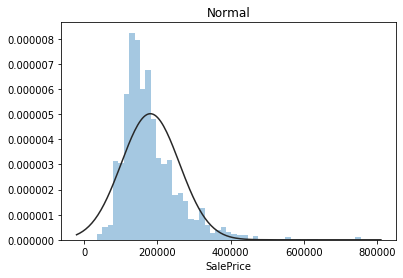

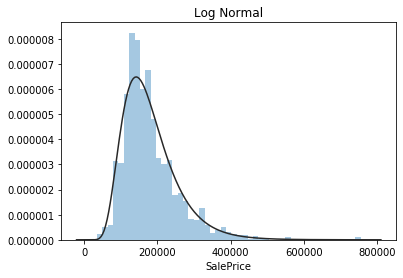

In [101]:
import seaborn as sns
y = df['SalePrice']
plt.figure(1); plt.title('Normal')
sns.distplot(y, kde=False, fit=stats.norm)
plt.figure(2); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=stats.lognorm)

### Data Cleansing


In [102]:
df_nulls = null_info(df)
df_nulls.head()
#df_nulls[df_nulls['%']>0].sort_values('%',ascending=False)

,key_0,#_NA,%,data_type
72,PoolQC,1453,99.520548,object
74,MiscFeature,1406,96.301370,object
6,Alley,1369,93.767123,object
73,Fence,1179,80.753425,object
57,FireplaceQu,690,47.260274,object


In [103]:
datasets.keys()

dict_keys(['0.test_original', '1.train_original'])

In [104]:
features = pd.concat([df.drop('SalePrice',axis=1),datasets['0.test_original']]).reset_index(drop=True)
df1 = fill_missing_values(features)

In [105]:
df1_nulls = null_info(df1)
df1_nulls[df1_nulls['%']>0].sort_values('%',ascending=False)

,key_0,#_NA,%,data_type


#### Correction of data types

In [106]:
df1['CentralAir'].unique()

array(['Y', 'N'], dtype=object)

In [107]:
#CentralAir -> transform to binary
df1['CentralAir'] = df1['CentralAir'].map(lambda x: 1 if x=='Y' else 0)

In [108]:
#Correct current numeric variables that represent categories: transform to string
to_string = ['MSSubClass','YearBuilt','YearRemodAdd','GarageYrBlt','MoSold','YrSold']
new_categorical = df1[to_string].astype(str)
df1.drop(to_string,axis=1,inplace=True)
df1 = pd.concat([df1,new_categorical],axis=1)

In [109]:
df1.MSSubClass.dtypes

dtype('O')

###  Variable Generation

In [110]:
df1['TotalArea'] = df1.PoolArea+df1.LotArea+df1.GrLivArea+df1.GarageArea

In [111]:
#features_subset = df.loc[:,['Neighborhood','TotalArea','OveralQual','HeatingQC','CentralAir','SaleCondition']]
df1['TotalLivingArea'] = df1['1stFlrSF']+df1['2ndFlrSF']

In [112]:
df1['YrBltAndRemod']=df1['YearBuilt']+df1['YearRemodAdd']
df1['TotalSF']=df1['TotalBsmtSF'] + df1['1stFlrSF'] + df1['2ndFlrSF']
 
df1['TotalSqrFootage'] = (df1['BsmtFinSF1'] + df1['BsmtFinSF2'] +
                                 df1['1stFlrSF'] + df1['2ndFlrSF'])
 
df1['TotalBathrooms'] = (df1['FullBath'] + (0.5 * df1['HalfBath']) +
                               df1['BsmtFullBath'] + (0.5 * df1['BsmtHalfBath']))
 
df1['TotalPorchSf'] = (df1['OpenPorchSF'] + df1['3SsnPorch'] +
                              df1['EnclosedPorch'] + df1['ScreenPorch'] +
                              df1['WoodDeckSF'])
df1['haspool'] = df1['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
df1['has2ndfloor'] = df1['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
df1['hasgarage'] = df1['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
df1['hasbsmt'] = df1['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
df1['hasfireplace'] = df1['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [113]:
datasets['2.train+test_cleaned+new features'] = df1

In [114]:
datasets.keys()

dict_keys(['0.test_original', '1.train_original', '2.train+test_cleaned+new features'])

### Variable Selection

#### Filtering features: Pearson correlation

In [115]:
data = datasets['2.train+test_cleaned+new features'].iloc[:len(datasets['1.train_original']),:]
data = pd.concat([data,datasets['1.train_original'].SalePrice],axis=1)
data = pd.get_dummies(data,drop_first=True).drop('Id',axis=1)
scaler = StandardScaler() 
numerical_std = pd.DataFrame(scaler.fit_transform(data),columns=data.columns)
numerical_std.head()

,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,CentralAir,...,YrBltAndRemod_20052007,YrBltAndRemod_20062006,YrBltAndRemod_20062007,YrBltAndRemod_20072007,YrBltAndRemod_20072008,YrBltAndRemod_20082008,YrBltAndRemod_20082009,YrBltAndRemod_20092009,YrBltAndRemod_20092010,YrBltAndRemod_20102010
0,0.212877,-0.207142,0.651479,-0.517200,0.514104,0.575425,-0.288653,-0.944591,-0.459303,0.263813,...,-0.045376,-0.180366,-0.120803,-0.154412,-0.101885,-0.105263,-0.069409,-0.098397,-0.052414,-0.02618
1,0.645747,-0.091886,-0.071836,2.179628,-0.570750,1.171992,-0.288653,-0.641228,0.466465,0.263813,...,-0.045376,-0.180366,-0.120803,-0.154412,-0.101885,-0.105263,-0.069409,-0.098397,-0.052414,-0.02618
2,0.299451,0.073480,0.651479,-0.517200,0.325915,0.092907,-0.288653,-0.301643,-0.313369,0.263813,...,-0.045376,-0.180366,-0.120803,-0.154412,-0.101885,-0.105263,-0.069409,-0.098397,-0.052414,-0.02618
3,0.068587,-0.096897,0.651479,-0.517200,-0.570750,-0.499274,-0.288653,-0.061670,-0.687324,0.263813,...,-0.045376,-0.180366,-0.120803,-0.154412,-0.101885,-0.105263,-0.069409,-0.098397,-0.052414,-0.02618
4,0.761179,0.375148,1.374795,-0.517200,1.366489,0.463568,-0.288653,-0.174865,0.199680,0.263813,...,-0.045376,-0.180366,-0.120803,-0.154412,-0.101885,-0.105263,-0.069409,-0.098397,-0.052414,-0.02618


In [116]:
numerical_std.shape

(1460, 984)

In [117]:
pearson_importance = pearson_filtering(numerical_std,'SalePrice',max_pvalue=0.05,min_abs_pearson=0.0)
pearson_importance.head()

,Corr_Coef,P-value
OverallQual,0.790982,2.185675e-313
TotalSF,0.782260,5.511173e-302
TotalLivingArea,0.716883,1.183941e-230
GrLivArea,0.708624,4.518034e-223
TotalSqrFootage,0.708047,1.497662e-222


In [118]:
pearson_importance.shape

(313, 2)

### Correlation and Integration

In [119]:
correlation = numerical_std.corr()
pre_selection = correlated_variables(correlation,'SalePrice')
pre_selection.head()

,Variable1,Variable2,Corr_V1&V2,Corr_V1&Obj,Corr_V2&Obj
0,YearBuilt_1875,YrBltAndRemod_18751996,1.0,-0.028655,-0.028655
0,YearRemodAdd_1954,YrBltAndRemod_19541954,1.0,-0.074066,-0.074066
0,ExterCond_Po,YrBltAndRemod_19401966,1.0,-0.034424,-0.034424
0,Exterior1st_CBlock,Exterior2nd_CBlock,1.0,-0.025028,-0.025028
0,YearRemodAdd_1967,YrBltAndRemod_19671967,1.0,-0.056700,-0.056700


In [120]:
#Filter strongly correlated variables
pre_selection.reset_index(drop=True,inplace=True)
result = []
max_correlation = 0.4
for i in pre_selection.index:
    if pre_selection.loc[i,'Corr_V1&V2'] < max_correlation:
        a = pre_selection.loc[i,'Corr_V1&Obj']
        b = pre_selection.loc[i,'Corr_V2&Obj']
        if a>=b:
            result.append(pre_selection.loc[i,'Variable1'])
        else:
            result.append(pre_selection.loc[i,'Variable2'])
result

['2ndFlrSF',
 'Foundation_PConc',
 'Condition1_Norm',
 'ExterQual_Gd',
 'Foundation_PConc',
 'BsmtFinSF1',
 'Condition2_Norm',
 'BsmtCond_TA',
 'SaleType_New',
 'OverallQual',
 'RoofMatl_Tar&Grv',
 'SaleCondition_Partial',
 'HouseStyle_2Story',
 'has2ndfloor',
 'MasVnrArea',
 'BsmtFinType2_Unf',
 'GarageQual_TA',
 'GarageType_Attchd',
 'Heating_GasA',
 'GarageCond_TA',
 'BsmtQual_Gd',
 'SaleCondition_Partial',
 'SaleType_New',
 'Foundation_PConc',
 '2ndFlrSF',
 'MasVnrType_BrkFace',
 'hasbsmt',
 'MSZoning_RL',
 'KitchenQual_Gd',
 'Electrical_SBrkr',
 'has2ndfloor',
 'ExterCond_TA',
 'ExterQual_Gd',
 'RoofStyle_Hip',
 'hasbsmt',
 'hasbsmt',
 'hasgarage',
 'hasbsmt']

In [121]:
pearson_feature_selection = list(set([i.split('_')[0] for i in result]))
pearson_feature_selection

['Condition2',
 'HouseStyle',
 'hasbsmt',
 'SaleType',
 'BsmtCond',
 '2ndFlrSF',
 'GarageCond',
 'has2ndfloor',
 'Heating',
 'SaleCondition',
 'RoofMatl',
 'KitchenQual',
 'ExterQual',
 'ExterCond',
 'Electrical',
 'RoofStyle',
 'MasVnrArea',
 'MasVnrType',
 'Condition1',
 'MSZoning',
 'GarageType',
 'GarageQual',
 'BsmtFinSF1',
 'hasgarage',
 'BsmtFinType2',
 'OverallQual',
 'BsmtQual',
 'Foundation']

In [122]:
len(pearson_feature_selection)

28

In [123]:
datasets.keys()

dict_keys(['0.test_original', '1.train_original', '2.train+test_cleaned+new features'])

In [124]:
datasets['3.train+test_pearson filtered'] = datasets['2.train+test_cleaned+new features'][pearson_feature_selection]
datasets['2.train+test_cleaned+new features'][pearson_feature_selection].shape

(2919, 28)

### Generate New Features from selected ones

In [125]:
datasets['3.train+test_pearson filtered'].dtypes

Condition2        object
HouseStyle        object
hasbsmt            int64
SaleType          object
BsmtCond          object
2ndFlrSF           int64
GarageCond        object
has2ndfloor        int64
Heating           object
SaleCondition     object
RoofMatl          object
KitchenQual       object
ExterQual         object
ExterCond         object
Electrical        object
RoofStyle         object
MasVnrArea       float64
MasVnrType        object
Condition1        object
MSZoning          object
GarageType        object
GarageQual        object
BsmtFinSF1       float64
hasgarage          int64
BsmtFinType2      object
OverallQual        int64
BsmtQual          object
Foundation        object
dtype: object

In [126]:
a = datasets['3.train+test_pearson filtered']
a.columns[a.dtypes == 'int64']
#[max(a[i]) for i in a[a.dtypes == 'int64']]
# dummie_features = datasets['4.selected variables'].dtypes=='uint8'
# datasets['4.selected variables']['sum_dummies'] = datasets['4.selected variables'].loc[:,dummie_features].sum(axis=1)
#table = datasets['4.selected variables'].groupby('sum_dummies').agg({'SalePrice':['mean','count','std']})
#table

Index(['hasbsmt', '2ndFlrSF', 'has2ndfloor', 'hasgarage', 'OverallQual'], dtype='object')

In [127]:
# datasets['4.selected variables'].boxplot(['SalePrice'],by='sum_dummies')

In [128]:
# numeric_features = datasets['4.selected variables'].loc[:,datasets['4.selected variables'].dtypes!='uint8']
# scaler = StandardScaler() 
# data_scaled = scaler.fit_transform(numeric_features)
# df_data_scaled = pd.DataFrame(data_scaled,columns=numeric_features.columns)
# df_data_scaled['sum_numeric'] = df_data_scaled.drop(['SalePrice','Id','sum_dummies'],axis=1).sum(axis=1)
# #df_data_scaled['sum_numeric_range'] = pd.cut(df_data_scaled['sum_numeric'].reset_index(drop=True),10)
# df_data_scaled.plot.scatter('sum_numeric','SalePrice')

In [129]:
# datasets['4.selected variables']['numeric_sum_std'] = df_data_scaled['sum_numeric']

## Modeling 1



In [130]:
datasets.keys()

dict_keys(['0.test_original', '1.train_original', '2.train+test_cleaned+new features', '3.train+test_pearson filtered'])

## Transform features


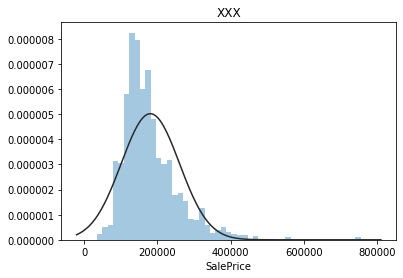

In [131]:
y = datasets['1.train_original']["SalePrice"]
plt.figure(1); plt.title('XXX')
sns.distplot(y, kde=False, fit=stats.norm)

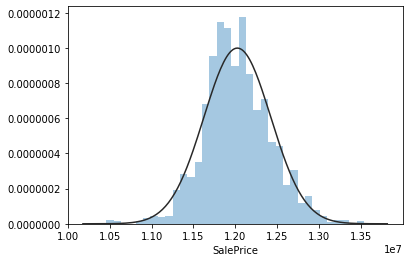

In [132]:
log_y = round(np.log1p(datasets['1.train_original']["SalePrice"])*1e6).astype(int)
sns.distplot(log_y,kde=False,fit=stats.norm)

In [133]:
def inverse_transform(data_transformed):
  try:
    return round(data_transformed.apply(lambda x: math.exp(x/1e6)-1)).astype(int)
  except:
    return (np.exp(data_transformed/1e6)-1).round().astype(int)

In [134]:
data = datasets['3.train+test_pearson filtered']
numeric_features = []
for i in data:
  if data[i].dtype != object and i not in ['hasgarage','hasbsmt','has2ndfloor']:
    numeric_features.append(i)
numeric_features = [i for i in numeric_features if i not in ['Id','SalePrice']]
numeric_features[0:10]


['2ndFlrSF', 'MasVnrArea', 'BsmtFinSF1', 'OverallQual']

In [135]:
skew_features = data[numeric_features].apply(lambda x: skew(x))#.sort_values(ascending=False)
skew_features.head()

2ndFlrSF       0.861675
MasVnrArea     2.613592
BsmtFinSF1     1.425230
OverallQual    0.197110
dtype: float64

In [136]:
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

for i in skew_index:
    data[i] = boxcox1p(data[i], boxcox_normmax(data[i] + 1))


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [137]:
final_features = pd.get_dummies(data).reset_index(drop=True)
to_sum = [i for i in data if data[i].dtypes=='float64' or i =='OverallQual']
final_features['sum_numerical'] = final_features.loc[:,to_sum].sum(axis=1)
x_train = final_features.iloc[:len(log_y),:]
datasets['5.all_features_log_transform'] = pd.concat([log_y,x_train],axis=1).reset_index(drop=True)
datasets['5.all_features_log_transform'].SalePrice

0       12247699
1       12109016
2       12317171
3       11849405
4       12429220
          ...   
1455    12072547
1456    12254868
1457    12493133
1458    11864469
1459    11901590
Name: SalePrice, Length: 1460, dtype: int32

### Train Models


In [138]:
data = datasets['5.all_features_log_transform']
x_train,x_test,y_train,y_test = train_test_split(data.drop(['SalePrice'],axis=1),data['SalePrice'], test_size=0.2,random_state=42)

In [139]:
def train_models(x_train,x_test,y_train,y_test):
    tree = DecisionTreeRegressor(max_depth=5,min_weight_fraction_leaf=0.03,random_state=42)
    rf = RandomForestRegressor(n_estimators = 50, random_state = 42, bootstrap=True
                               #,max_samples=0.5
                               ,min_weight_fraction_leaf=0.01
                              )
    xgboost = XGBRegressor(n_estimators=100,early_stopping_rounds=5,eval_set=[(x_test, y_test)])
    mod_list = {'lin_reg':LinearRegression(),'svm':svm.SVR(kernel='linear'),'tree':tree,'random_forest':rf,'xgboost':xgboost}
    perf_metrics = ['R^2','MAE','RMSE','MAPE','RMSLE']
    results = pd.DataFrame(columns=perf_metrics)

    for i in mod_list:
        #Train models
        mod_list[i].fit(x_train,y_train)
        y_pred = mod_list[i].predict(x_test)
        #Transform y_test and y_pred to original values if needed
        y_test2 = inverse_transform(y_test)
        y_pred2 = inverse_transform(y_pred)
        r2 = mod_list[i].score(x_test, y_test)
        mae = metrics.mean_absolute_error(y_pred2,y_test2)
        rmse = np.sqrt(metrics.mean_squared_error(y_pred2,y_test2))
        mape = mean_absolute_percentage_error(y_test2,y_pred2)
        rmsle = ''
        try:
            rmsle = np.sqrt(metrics.mean_squared_log_error(y_test2,y_pred2))
        except:
            pass
        line = pd.DataFrame(data=[[r2,mae,rmse,mape,rmsle]],index=[i],columns=results.columns)
        results = pd.concat([results,line],axis=0)
    
    return results,mod_list

In [140]:
results,mod_list = train_models(x_train,x_test,y_train,y_test)
results

overflow encountered in exp


[18:33:04] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { early_stopping_rounds, eval_set } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




,R^2,MAE,RMSE,MAPE,RMSLE
lin_reg,-5.338034e+12,7.376957e+06,16694.558814,3058.881776,
svm,3.816442e-01,4.510544e+04,16150.133785,25.831825,0.339694
tree,7.390947e-01,2.849490e+04,15129.963339,16.960046,0.220653
random_forest,8.059434e-01,2.232840e+04,15898.719307,13.352731,0.190298
xgboost,8.060822e-01,2.330445e+04,14260.166977,13.341812,0.190229


In [141]:
# Cross Validation
X = datasets['5.all_features_log_transform'].drop(['SalePrice'],axis=1)                                         
y = datasets['5.all_features_log_transform']['SalePrice']
metric = 'neg_mean_squared_log_error'
print('Cross Validation: \n',metric,':')
np.mean(np.sqrt(np.absolute(cross_val_score(mod_list['xgboost'],X, y, cv=5, scoring=metric))))

Cross Validation: 
 neg_mean_squared_log_error :
[18:33:04] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { early_stopping_rounds, eval_set } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:33:05] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { early_stopping_rounds, eval_set } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:33:05] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { early_stopping_ro

0.015327672277288007

In [142]:
# # Plot Decision Tree
# model = mod_list['random_forest'].estimators_[2]
# model.get_depth()
# plt.figure(figsize=(120,50))
# a = plot_tree(model, 
#               feature_names=x_train.columns, 
#               #class_names=breast_cancer.target_names, 
#               filled=True, 
#               rounded=True, 
#               fontsize=40)

In [143]:
datasets.keys()

dict_keys(['0.test_original', '1.train_original', '2.train+test_cleaned+new features', '3.train+test_pearson filtered', '5.all_features_log_transform'])

### Submission File

In [188]:
y = datasets['1.train_original']['SalePrice']
x_train = final_features.iloc[:len(y),:]
y_train = log_y
x_test = final_features.iloc[len(y):,:]
xgboost = XGBRegressor(n_estimators=100,early_stopping_rounds=5,enable_experimental_json_serialization=True)
xgboost.fit(x_train,y_train)

[16:57:31] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=5,
             enable_experimental_json_serialization=True, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [189]:
xgboost.save_model('house_prices_xgboost.json')
with open('house_prices_xgboost.json', 'wb') as fd:
    pickle.dump(xgboost, fd)

In [185]:
x_train.to_csv('train_transformed.csv')

In [194]:
inverse_transform(pd.DataFrame(xgboost.predict(x_train.iloc[0:10,:]))).to_numpy()

array([[211930],
       [174805],
       [219960],
       [145443],
       [266409],
       [144079],
       [309564],
       [201782],
       [130200],
       [120866]])

In [145]:
submission = pd.read_csv('https://raw.githubusercontent.com/tgrasty/house_prices/master/sample_submission.csv')
submission.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [146]:
submission.iloc[:,1] = inverse_transform(xgboost.predict(x_test))
submission.set_index(submission['Id'],inplace=True)
submission.drop('Id',axis=1,inplace=True)
submission.head()

,SalePrice
Id,
1461,111469
1462,172263
1463,169883
1464,172003
1465,202968


In [147]:
submission.shape

(1459, 1)

In [148]:
submission.to_csv('house_prices-submission.csv')